In [2]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment 
import matplotlib.pyplot as plt
import cv2
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
import matplotlib.patches as mpatches
import os 
from pyquaternion import Quaternion
from PIL import Image
import os
from filterpy.kalman import KalmanFilter
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform
from sklearn.metrics import mean_squared_error


nusc = NuScenes(version='v1.0-mini', dataroot='/Users/stefano_ruggiero/Desktop/3Dperc_p2/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.403 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
my_scene = nusc.scene[0]

In [4]:
my_sample = nusc.sample[10]

In [5]:
# nuscenes-lidarseg
#nusc.get_sample_lidarseg_stats(my_sample['token'], sort_by='count')

In [6]:
def get_calibrated_points(nusc, pointsensor_token, camera_token):
    # Carica il point cloud usando il token del sensore LiDAR
    pcl_path = nusc.get_sample_data_path(pointsensor_token)  # Percorso del file del point cloud
    pc = LidarPointCloud.from_file(pcl_path)  # Carica il point cloud da file

    # Ottieni i record relativi al sensore LiDAR e alla posa del veicolo ego
    lidar_sd_record = nusc.get('sample_data', pointsensor_token)  # Ottieni il record dei dati LiDAR
    cs_record_lidar = nusc.get('calibrated_sensor', lidar_sd_record['calibrated_sensor_token'])  # Ottieni i dati di calibrazione del sensore LiDAR
    pose_record_lidar = nusc.get('ego_pose', lidar_sd_record['ego_pose_token'])  # Ottieni la posa del veicolo al momento dell'acquisizione

    # Trasforma il point cloud dal frame del sensore LiDAR al frame del veicolo ego
    pc.rotate(Quaternion(cs_record_lidar['rotation']).rotation_matrix)  # Ruota i punti usando la matrice di rotazione del sensore LiDAR
    pc.translate(np.array(cs_record_lidar['translation']))  # Trasla i punti per allinearli al centro del veicolo ego

    # Trasforma il point cloud nel frame globale
    pc.rotate(Quaternion(pose_record_lidar['rotation']).rotation_matrix)  # Ruota i punti al frame globale usando la rotazione dell'ego
    pc.translate(np.array(pose_record_lidar['translation']))  # Trasla i punti per posizionarli nel sistema di coordinate globale

    # Ottieni i record del sensore della telecamera e della posa ego
    cam_sd_record = nusc.get('sample_data', camera_token)  # Ottieni il record del sensore della telecamera
    cs_record_cam = nusc.get('calibrated_sensor', cam_sd_record['calibrated_sensor_token'])  # Ottieni i dati di calibrazione del sensore della telecamera
    pose_record_cam = nusc.get('ego_pose', cam_sd_record['ego_pose_token'])  # Ottieni la posa del veicolo al momento dell'acquisizione della telecamera

    # Trasforma il point cloud dal frame globale al frame del veicolo ego al timestamp della telecamera
    pc.translate(-np.array(pose_record_cam['translation']))  # Trasla i punti al centro del veicolo ego rispetto al frame globale
    pc.rotate(Quaternion(pose_record_cam['rotation']).rotation_matrix.T)  # Ruota i punti nel frame dell'ego usando la rotazione inversa

    # Trasforma il point cloud dal frame del veicolo al frame della telecamera
    pc.translate(-np.array(cs_record_cam['translation']))  # Trasla i punti per allinearli con la telecamera
    pc.rotate(Quaternion(cs_record_cam['rotation']).rotation_matrix.T)  # Ruota i punti nel frame della telecamera usando la rotazione inversa

    # Proietta i punti sul piano dell'immagine
    cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])  # Matrice intrinseca della telecamera (parametri di proiezione)
    points_3d_cam = pc.points[:3, :]  # Punti 3D nel frame della telecamera (x, y, z)
    points_2d = view_points(points_3d_cam, cam_intrinsic, normalize=True)  # Proiezione dei punti nel piano 2D dell'immagine

    return points_2d, points_3d_cam  # Restituisce i punti proiettati (2D) e i punti originali nel frame della telecamera (3D)


In [7]:
def visualize_calibrated_points(nusc, camera_token, points_2d):
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Filtra i punti che rientrano nelle dimensioni dell'immagine
    width, height = img_np.shape[1], img_np.shape[0]
    valid_points = (points_2d[0, :] >= 0) & (points_2d[0, :] < width) & \
                   (points_2d[1, :] >= 0) & (points_2d[1, :] < height)
    points_2d_filtered = points_2d[:, valid_points]

    plt.figure(figsize=(10, 6))
    plt.imshow(img_np)
    plt.scatter(points_2d_filtered[0, :], points_2d_filtered[1, :], c='red', s=5, label='Punti LiDAR Calibrati')
    plt.xlabel("Coordinata X (pixel)")
    plt.ylabel("Coordinata Y (pixel)")
    plt.legend()
    plt.title("Punti LiDAR Calibrati sulla Vista della Camera")
    plt.show()


In [8]:
def get_projected_boxes(nusc, camera_token):
    # Ottieni i dati associati alla telecamera utilizzando il suo token
    cam_data = nusc.get('sample_data', camera_token)

    # Ottieni il percorso del file dell'immagine della telecamera, 
    # tutte le bounding boxes 3D visibili e la matrice intrinseca della telecamera
    _, boxes, cam_intrinsic = nusc.get_sample_data(camera_token, box_vis_level=BoxVisibility.ALL)

    # Crea una lista vuota per salvare le bounding boxes proiettate sul piano dell'immagine 2D
    projected_boxes = []

    # Itera su ciascuna bounding box 3D nella lista `boxes`
    for box in boxes:
        # Ottieni le coordinate 3D degli 8 angoli della bounding box
        corners_3d = box.corners()

        # Proietta i punti 3D sul piano dell'immagine 2D usando la matrice intrinseca della telecamera
        # La funzione `view_points` restituisce le coordinate proiettate
        # `normalize=True` normalizza i punti per ottenere coordinate omogenee
        # `[:2, :]` seleziona le prime due righe, ovvero le coordinate x e y
        corners_2d = view_points(corners_3d, cam_intrinsic, normalize=True)[:2, :]

        # Aggiungi le coordinate 2D degli 8 angoli alla lista delle bounding boxes proiettate
        projected_boxes.append(corners_2d)

    # Restituisci la lista di bounding boxes proiettate in 2D
    return projected_boxes


In [9]:
def get_projected_boxes_with_labels(nusc, camera_token):
    cam_data = nusc.get('sample_data', camera_token)
    _, boxes, cam_intrinsic = nusc.get_sample_data(camera_token, box_vis_level=BoxVisibility.ALL)
    
    projected_boxes = []
    box_labels = []
    for box in boxes:
        corners_3d = box.corners()
        corners_2d = view_points(corners_3d, cam_intrinsic, normalize=True)[:2, :]
        projected_boxes.append(corners_2d)
        box_labels.append(box.name)  # Recupera l'etichetta originale
    
    return projected_boxes, box_labels


In [10]:
def associate_points_to_boxes(points_2d, boxes_2d):
    # Creazione della matrice dei costi che verrà utilizzata per il problema di assegnazione
    cost_matrix = []

    # Itera su ciascun punto (proiettato in 2D) da associare
    for point in points_2d.T:  # `points_2d.T` trasposta per iterare sui singoli punti come colonne
        costs = []

        # Itera su ciascuna bounding box (in 2D)
        for box in boxes_2d:
            # Calcola il centro della bounding box facendo la media delle coordinate degli angoli
            box_center = np.mean(box, axis=1)

            # Calcola la distanza euclidea tra il punto e il centro della bounding box
            cost = np.linalg.norm(point[:2] - box_center[:2])  # Distanza euclidea tra il punto e il centro della box

            # Aggiunge il costo (distanza) alla lista dei costi
            costs.append(cost)

        # Aggiunge la lista dei costi per il punto corrente alla matrice dei costi
        cost_matrix.append(costs)

    # Converte la matrice dei costi in un array NumPy
    cost_matrix = np.array(cost_matrix)

    # Utilizza l'algoritmo di assegnazione lineare (algoritmo ungherese) per trovare l'assegnazione ottimale
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    # Filtra le associazioni per rimuovere le eventuali associazioni con il padding (evitare errori fuori dai limiti)
    associations = [(row, col) for row, col in zip(row_indices, col_indices)
                    if row < len(points_2d.T) and col < len(boxes_2d)]

    # Restituisce la lista delle associazioni tra punti e bounding boxes
    return associations


In [11]:
def get_box_labels_from_camera(nusc, camera_token):
    # Ottieni i dati relativi alla telecamera utilizzando il suo token
    cam_data = nusc.get('sample_data', camera_token)
    
    # Ottieni il campione associato alla telecamera
    my_sample = nusc.get('sample', cam_data['sample_token'])
    
    # Ottieni le informazioni di calibrazione del sensore della telecamera
    calibrated_sensor = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    
    # Ottieni la matrice intrinseca della telecamera per la proiezione dei punti
    cam_intrinsic = np.array(calibrated_sensor['camera_intrinsic'])
    
    # Inizializza le liste vuote per etichette, bounding boxes 2D, e token validi
    box_labels = []
    boxes_2d = []
    valid_tokens = []  # Nuova lista per i token validi
    
    # Itera su ciascun token di annotazione presente nel campione
    for ann_token in my_sample['anns']:
        # Ottieni i dati della box 3D usando il token di annotazione
        box_3d = nusc.get('sample_annotation', ann_token)
        
        # Ottieni il nome della categoria dell'oggetto (es: veicolo, pedone)
        category_name = box_3d['category_name']
        
        # Ottieni la bounding box 3D dell'oggetto usando il token di annotazione
        box = nusc.get_box(ann_token)
        
        # Calcola le coordinate 3D degli 8 angoli della box
        corners_3d = box.corners()
        
        # Proietta i punti 3D sul piano dell'immagine 2D usando la matrice intrinseca della telecamera
        corners_2d = view_points(corners_3d, cam_intrinsic, normalize=True)[:2, :]
        
        # Verifica se tutti i punti della box proiettata sono visibili all'interno dell'immagine
        if np.all(corners_2d[0, :] > 0) and np.all(corners_2d[0, :] < cam_data['width']) and \
           np.all(corners_2d[1, :] > 0) and np.all(corners_2d[1, :] < cam_data['height']):
            # Aggiungi la bounding box 2D alla lista `boxes_2d`
            boxes_2d.append(corners_2d)
            
            # Aggiungi il nome della categoria dell'oggetto alla lista `box_labels`
            box_labels.append(category_name)
            
            # Aggiungi il token di annotazione valido alla lista `valid_tokens`
            valid_tokens.append(ann_token)
    
    # Restituisci le etichette delle bounding boxes, le bounding boxes 2D, e i token validi
    return box_labels, boxes_2d, valid_tokens


In [12]:
def visualize_associations(nusc, camera_token, points_2d, boxes_2d, associations):
    # Carica l'immagine della camera associata al token fornito
    cam = nusc.get('sample_data', camera_token)
    
    # Ottieni il percorso del file dell'immagine della camera
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    
    # Apri l'immagine utilizzando la libreria PIL
    img = Image.open(img_path)
    
    # Converti l'immagine in un array NumPy
    img_np = np.array(img)
    
    # Converti l'immagine da BGR a RGB (OpenCV usa BGR, mentre la maggior parte delle librerie usa RGB)
    image_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    
    # Imposta le dimensioni della figura per visualizzare l'immagine
    plt.figure(figsize=(10, 6))
    
    # Mostra l'immagine caricata come sfondo del grafico
    plt.imshow(image_rgb)
    
    # Disegna i bounding boxes 2D
    for i, box in enumerate(boxes_2d):
        # Disegna una linea che collega i 4 angoli del box per formare il rettangolo
        plt.plot(box[0, [0, 1, 2, 3, 0]], box[1, [0, 1, 2, 3, 0]], 'b-', label="Box" if i == 0 else "")
    
    # Disegna i punti LiDAR proiettati e le loro associazioni con le bounding boxes
    for i, (point_idx, box_idx) in enumerate(associations):
        # Ottieni le coordinate del punto LiDAR associato
        point = points_2d[:, point_idx]
        
        # Calcola il centro della bounding box associata
        box_center = np.mean(boxes_2d[box_idx], axis=1)
        
        # Disegna il punto LiDAR sulla figura
        plt.plot(point[0], point[1], 'ro')  # 'ro' indica un punto rosso (red circle)
        
        # Disegna una linea tratteggiata tra il punto LiDAR e il centro della bounding box associata
        plt.plot([point[0], box_center[0]], [point[1], box_center[1]], 'r--', linewidth=0.5)  # 'r--' indica una linea rossa tratteggiata
    
    # Aggiungi le etichette degli assi
    plt.xlabel("Coordinata X (pixel)")
    plt.ylabel("Coordinata Y (pixel)")
    
    # Aggiungi un titolo alla figura
    plt.title("Associazione tra punti LiDAR e bounding box nella vista della camera")
    
    # Aggiungi una legenda
    plt.legend()
    
    # Mostra la figura
    plt.show()


In [13]:
def visualize_associations_with_labels(nusc, camera_token, points_2d, boxes_2d, box_labels, associations):
    # Carica l'immagine della camera
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    img_height, img_width, _ = img_np.shape

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.axis('off')

    # Creare una lista di colori distinti
    unique_labels = list(set(box_labels))
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('hsv', num_labels)

    # Creare un dizionario che mappa le etichette ai colori
    label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Disegna i bounding box e le categorie
    for i, box in enumerate(boxes_2d):
        label = box_labels[i]
        color = label_color_map[label]
        plt.plot(box[0, [0, 1, 2, 3, 0]], box[1, [0, 1, 2, 3, 0]], color=color, linewidth=2)
        
        # Aggiungi la categoria del box come testo al centro del box
        box_center = np.mean(box, axis=1)
        plt.text(box_center[0], box_center[1] - 10, label, color=color, fontsize=12, ha='center')

    # Disegna i punti associati ai box
    for i, (point_idx, box_idx) in enumerate(associations):
        point = points_2d[:, point_idx]
        if (0 <= point[0] <= img_width) and (0 <= point[1] <= img_height):
            label = box_labels[box_idx]
            color = label_color_map[label]
            # Disegna il punto lidar
            plt.plot(point[0], point[1], 'o', color=color, markersize=4)
            # Disegna una linea di associazione
            box_center = np.mean(boxes_2d[box_idx], axis=1)
            plt.plot([point[0], box_center[0]], [point[1], box_center[1]], '--', color=color, linewidth=0.5)

    # Aggiungi una legenda per le categorie
    legend_patches = [mpatches.Patch(color=label_color_map[label], label=label) for label in unique_labels]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.title("Associazione tra punti Lidar e bounding box con etichette originali")
    plt.show()


In [14]:
def visualize_associations_with_legend(nusc, camera_token, points_2d, boxes_2d, box_labels, associations):
    # Carica l'immagine della camera
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    img_height, img_width, _ = img_np.shape

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.axis('off')

    # Creare una lista di colori distinti
    unique_labels = list(set(box_labels))
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('tab20', num_labels)  # Usa una colormap con più colori

    # Creare un dizionario che mappa le etichette ai colori
    label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Disegna i bounding box con colori corrispondenti alle etichette
    for i, box in enumerate(boxes_2d):
        label = box_labels[i]
        color = label_color_map[label]
        plt.plot(box[0, [0, 1, 2, 3, 0]],
                 box[1, [0, 1, 2, 3, 0]],
                 color=color,
                 linewidth=2)

        # Rimuovi le etichette dall'immagine
        # box_center = np.mean(box, axis=1)
        # plt.text(box_center[0], box_center[1] - 10, label, color=color, fontsize=10, ha='center',
        #          bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Disegna i punti associati ai box
    for i, (point_idx, box_idx) in enumerate(associations):
        point = points_2d[:, point_idx]
        if (0 <= point[0] <= img_width) and (0 <= point[1] <= img_height):
            label = box_labels[box_idx]
            color = label_color_map[label]
            # Disegna il punto Lidar
            plt.plot(point[0], point[1], 'o', color=color, markersize=3)
            # Disegna una linea di associazione
            box_center = np.mean(boxes_2d[box_idx], axis=1)
            plt.plot([point[0], box_center[0]], [point[1], box_center[1]],
                     '-', color=color, linewidth=0.5, alpha=0.5)

    # Aggiungi una legenda per le categorie
    legend_patches = [mpatches.Patch(color=label_color_map[label], label=label) for label in unique_labels]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.title("Associazione tra punti Lidar e bounding box con legenda delle etichette")
    plt.show()


In [15]:
def calculate_velocities(positions, dt=0.5):  # `dt` = 0,5 secondi --> 2 Hz (frequenza di campionamento)
    # Inizializza una lista vuota per salvare le velocità calcolate
    velocities = []
    
    # Itera su ogni posizione a partire dalla seconda (indice 1) fino alla fine della lista
    for i in range(1, len(positions)):
        # Calcola la differenza nelle coordinate x tra la posizione corrente e quella precedente
        dx = positions[i][0] - positions[i - 1][0]
        
        # Calcola la differenza nelle coordinate y tra la posizione corrente e quella precedente
        dy = positions[i][1] - positions[i - 1][1]
        
        # Calcola la velocità lungo l'asse x dividendo lo spostamento per il tempo `dt`
        vx = dx / dt
        
        # Calcola la velocità lungo l'asse y dividendo lo spostamento per il tempo `dt`
        vy = dy / dt
        
        # Aggiunge la velocità (come lista [vx, vy]) alla lista delle velocità
        velocities.append([vx, vy])
    
    # Restituisce la lista delle velocità calcolate
    return velocities


In [16]:

def calculate_rmse(predictions, ground_truth_positions):
    rmse_values = []
    for i, (pred, gt_positions) in enumerate(zip(predictions, ground_truth_positions)):
        if gt_positions:
            # Calcola RMSE per ogni oggetto nel frame corrente
            frame_rmse = []
            for gt in gt_positions:
                rmse = np.sqrt(mean_squared_error(pred, gt))
                frame_rmse.append(rmse)
            # Media degli RMSE per il frame corrente
            avg_frame_rmse = np.mean(frame_rmse)
            rmse_values.append(avg_frame_rmse)
    # Media degli RMSE tra i frame
    overall_rmse = np.mean(rmse_values)
    return overall_rmse

In [17]:
def get_ground_truth_positions(nusc, scene):
    # Ottieni il primo sample token della scena
    sample_token = scene['first_sample_token']
    ground_truth_positions = []

    # Itera su tutti i frame della scena
    while sample_token:
        sample = nusc.get('sample', sample_token)
        sample_data_token = sample['data']['LIDAR_TOP']  # Assumi che il Lidar sia il sensore di riferimento
        boxes = nusc.get_boxes(sample_data_token)  # Ottieni le annotazioni per il frame corrente

        frame_positions = []
        for box in boxes:
            # Aggiungi la posizione [x, y] del centro dell'oggetto al frame corrente
            frame_positions.append([box.center[0], box.center[1]])

        ground_truth_positions.append(frame_positions)
        
        # Passa al prossimo frame
        sample_token = sample['next']
    
    return ground_truth_positions

ground_truth_positions = get_ground_truth_positions(nusc, my_scene)

In [18]:
def visualize_fused_positions_on_image(nusc, camera_token, fused_positions, boxes_2d, box_labels):
    cam = nusc.get('sample_data', camera_token)
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    img_height, img_width, _ = img_np.shape

    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    plt.axis('off')

    unique_labels = list(set(box_labels))
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('tab20', num_labels)  # Use colormap for unique colors

    label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

    for i, box in enumerate(boxes_2d):
        label = box_labels[i]
        color = label_color_map[label]
        plt.plot(box[0, [0, 1, 2, 3, 0]],
                 box[1, [0, 1, 2, 3, 0]],
                 color=color,
                 linewidth=2)

    for i, pos in enumerate(fused_positions):
        plt.plot(pos[0], pos[1], 'x', color='red', markersize=10, markeredgewidth=2)
        plt.text(pos[0], pos[1] - 10, f'Fused {i + 1}', color='red', fontsize=12, ha='center')

    legend_patches = [mpatches.Patch(color=label_color_map[label], label=label) for label in unique_labels]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.title("Fused Positions from Kalman Filter on Original Image")
    plt.show()


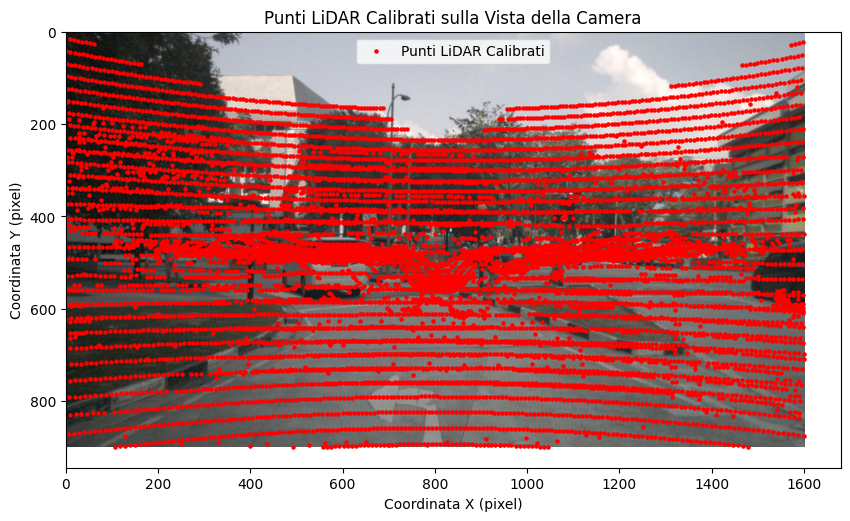

In [19]:
pointsensor_token = my_sample['data']['LIDAR_TOP'] 
camera_token = my_sample['data']['CAM_FRONT']

# Ottieni punti proiettati e bounding box con etichette
projected_points, points_3d_cam = get_calibrated_points(nusc, pointsensor_token, camera_token)
boxes_2d, box_labels = get_projected_boxes_with_labels(nusc, camera_token)

visualize_calibrated_points(nusc, camera_token, projected_points)

# Effettua la data association
associations = associate_points_to_boxes(projected_points, boxes_2d)


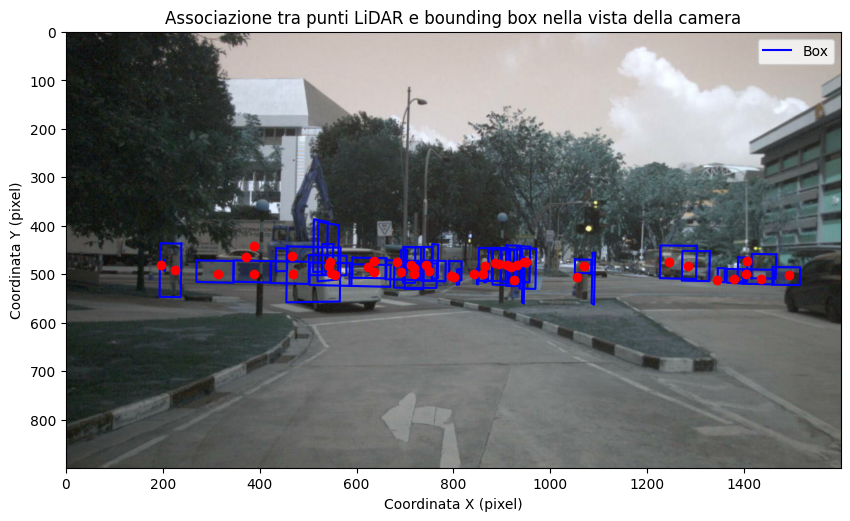

In [20]:
# Visualizza i risultati
visualize_associations(nusc, camera_token, projected_points, boxes_2d, associations)

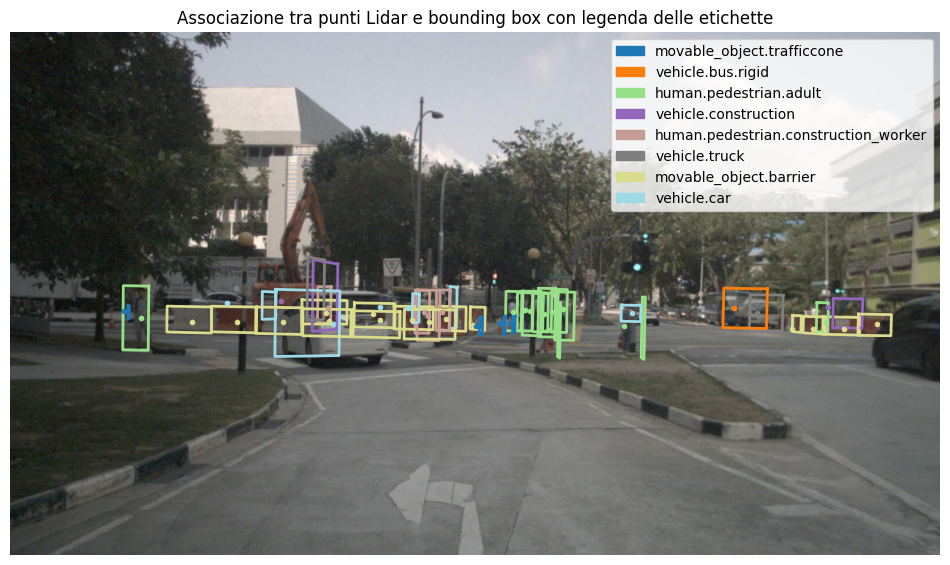

In [21]:
# Visualizza i risultati con la legenda
visualize_associations_with_legend(nusc, camera_token, projected_points, boxes_2d, box_labels, associations)

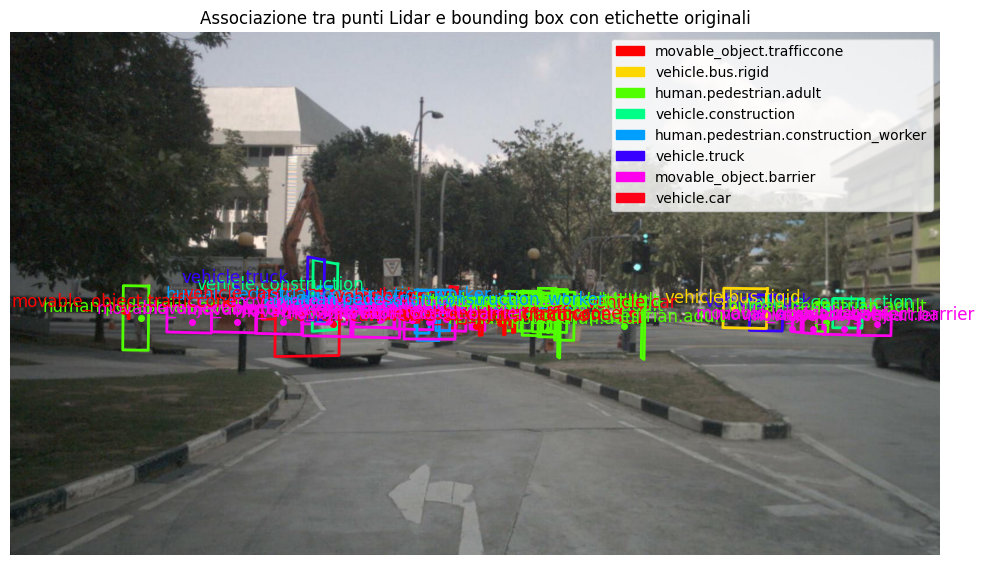

In [22]:
# Visualizza i risultati con le etichette 
visualize_associations_with_labels(nusc, camera_token, projected_points, boxes_2d, box_labels, associations)

SENSOR DATA FUSION FILTRO KALMAN

In [23]:
class SensorFusionKF:
    def __init__(self, dt, process_var, measurement_var):
        # Inizializza il filtro di Kalman con 4 dimensioni di stato (x, vx, y, vy) e 2 dimensioni di misura (x, y)
        self.kf = KalmanFilter(dim_x=4, dim_z=2)

        # Definisce la matrice di transizione di stato (F) per aggiornare lo stato nel tempo
        self.kf.F = np.array([[1, dt, 0, 0],   # x = x + vx * dt
                              [0, 1,  0, 0],   # vx = vx (velocità costante)
                              [0, 0,  1, dt],  # y = y + vy * dt
                              [0, 0,  0, 1]])  # vy = vy (velocità costante)

        # Definisce la matrice di osservazione (H) che mappa lo stato alle misure (x, y)
        self.kf.H = np.array([[1, 0, 0, 0],    # Osserva x
                              [0, 0, 1, 0]])   # Osserva y

        # Rumore di misura e di processo
        self.kf.R *= measurement_var  # Rumore nella misura
        self.kf.Q = np.eye(4) * process_var  # Rumore del processo, modello di incertezza nello stato

        # Stato iniziale e matrice di covarianza dell'incertezza
        self.kf.x = np.zeros(4)  # Stato iniziale [x, vx, y, vy] tutto a zero
        self.kf.P *= 500.  # Incertezza iniziale piuttosto grande

    def predict(self):
        # Predice il prossimo stato utilizzando la matrice di transizione
        self.kf.predict()
        return self.kf.x[:2]  # Ritorna solo la posizione [x, y] dopo la predizione

    def update(self, measurement):
        # Aggiorna lo stato del filtro di Kalman con una nuova misura (posizione rilevata)
        self.kf.update(measurement)

    def fuse_data(self, lidar_data, camera_data, associations):
        fused_positions = []
        for point_idx, box_idx in associations:
            lidar_point = lidar_data[:, point_idx][:2]  # Posizione [x, y] da LiDAR
            camera_point = camera_data[box_idx].mean(axis=1)  # Media dei vertici del box della telecamera come [x, y]

            # Predice lo stato
            self.predict()

            # Fusione dei dati da LiDAR e telecamera
            combined_measurement = (lidar_point + camera_point) / 2  # Media delle posizioni (fusione semplice)

            # Aggiorna il filtro di Kalman con la misura fusa
            self.update(combined_measurement)

            # Salva la posizione fusa
            fused_positions.append(self.kf.x[:2])

        return fused_positions


    def print_fused_positions(self, fused_positions):
        # Stampa le posizioni fuse
        print("Fused Positions (x, y):")
        for idx, pos in enumerate(fused_positions):
            print(f"Object {idx + 1}: x = {pos[0]:.2f}, y = {pos[1]:.2f}")

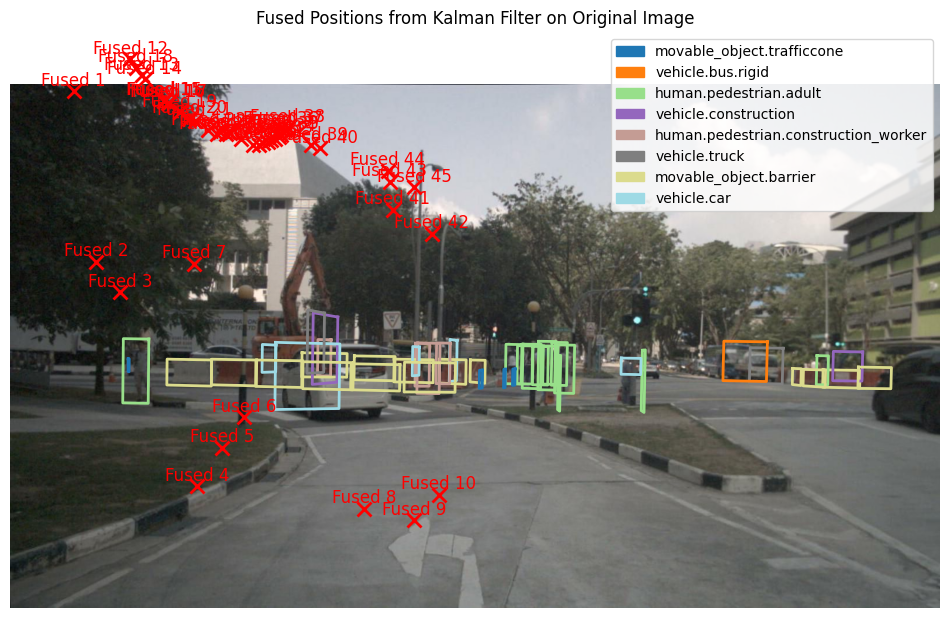

In [24]:
# Initialize SensorFusionKF with suitable parameters
fusion_kf = SensorFusionKF(dt=0.1, process_var=1.0, measurement_var=0.5)

# Fused positions
fused_positions = fusion_kf.fuse_data(points_3d_cam, boxes_2d, associations)

#fusion_kf.print_fused_positions(fused_positions)

# Plot dei risultati
visualize_fused_positions_on_image(nusc, camera_token, fused_positions, boxes_2d, box_labels)


In [25]:
overall_rmse = calculate_rmse(fused_positions, ground_truth_positions)
print(f"RMSE totale sulle predizioni: {overall_rmse:.2f}")

RMSE totale sulle predizioni: 681.91


PREDICTIONS CON PARTICLES FILTER

In [26]:
class ParticleFilter:
    def __init__(self, num_particles, initial_position, process_var, measurement_var):
        #process_var controlla quanto rumore si aggiunge durante il processo di predizione del movimento, influenzando la dispersione delle particelle. 
        #measurement_var gestisce l'incertezza nella fase di aggiornamento basata sulle misure, influenzando la precisione del filtro nell'adattarsi alle osservazioni del sensore.

        # Numero di particelle
        self.num_particles = num_particles
        
        # Inizializzazione delle particelle e dei pesi
        self.particles = np.empty((self.num_particles, 2))  # Ogni particella rappresenta una posizione [x, y]
        # Inizializza le posizioni delle particelle attorno alla posizione iniziale con rumore uniforme
        self.particles[:, 0] = initial_position[0] + uniform(-1, 1, size=self.num_particles)
        self.particles[:, 1] = initial_position[1] + uniform(-1, 1, size=self.num_particles)
        # Inizializza i pesi di ogni particella uguali, poiché non abbiamo ancora informazioni specifiche
        self.weights = np.ones(self.num_particles) / self.num_particles

        # Varianza del processo e della misura, che rappresentano l'incertezza nei movimenti e nelle misure
        self.process_var = process_var
        self.measurement_var = measurement_var

    def predict(self, velocity):
        """ Aggiorna le particelle in base alla velocità stimata """
        # Aggiorna le posizioni delle particelle tenendo conto della velocità stimata e del rumore del processo
        self.particles[:, 0] += velocity[0] + np.random.randn(self.num_particles) * self.process_var
        self.particles[:, 1] += velocity[1] + np.random.randn(self.num_particles) * self.process_var

    def update(self, measurement):
        """ Aggiorna i pesi delle particelle in base alla misura corrente """
        # Calcola la distanza euclidea tra ogni particella e la misura corrente
        distances = np.linalg.norm(self.particles - measurement, axis=1)
        # Aggiorna i pesi delle particelle in base alla probabilità di osservare la misura data la posizione della particella
        self.weights *= np.exp(- (distances ** 2) / (2 * self.measurement_var))
        # Aggiunge un piccolo valore ai pesi per evitare che diventino esattamente zero
        self.weights += 1.e-300
        # Normalizza i pesi per fare in modo che la loro somma sia pari a 1
        self.weights /= sum(self.weights)

    def resample(self):
        """ Esegue il resampling delle particelle """
        # Esegue il resampling delle particelle in base ai pesi utilizzando il metodo di resampling sistematico
        indices = systematic_resample(self.weights)
        # Aggiorna le particelle con le particelle selezionate in base ai pesi
        self.particles = self.particles[indices]
        # Reimposta i pesi di tutte le particelle a valori uniformi dopo il resampling
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        """ Stima la posizione corrente come media ponderata delle particelle """
        # Calcola la posizione stimata attuale come media ponderata delle posizioni delle particelle
        return np.average(self.particles, weights=self.weights, axis=0)

    def run_filter(self, fused_data, velocities):
        """ Esegue il filtro sulle posizioni fuse """
        predictions = []
        # Itera su ogni misura e velocità fornite
        for i, (measurement, velocity) in enumerate(zip(fused_data, velocities)):
            # Predice la nuova posizione delle particelle basandosi sulla velocità
            self.predict(velocity)
            
            # Aggiorna i pesi delle particelle sulla base della misura corrente
            self.update(measurement)
            
            # Esegue il resampling delle particelle se la varianza dei pesi è troppo grande
            if 1. / np.sum(self.weights ** 2) < self.num_particles / 2:
                self.resample()
                
            # Stima la posizione corrente come media ponderata delle particelle e la aggiunge ai risultati
            predictions.append(self.estimate())
        
        return predictions


In [ ]:
# Inizializza il filtro a particelle
particle_filter = ParticleFilter(num_particles=1000, initial_position=fused_positions[0], process_var=1.0, measurement_var=2.0)

velocities = calculate_velocities(fused_positions)

# Esegui il filtro a particelle sui dati fusi
predictions = particle_filter.run_filter(fused_positions, velocities)

# Stampa le predizioni
#for i, pred in enumerate(predictions):
    #print(f"Prediction {i + 1}: x = {pred[0]:.2f}, y = {pred[1]:.2f}")

ValueError: operands could not be broadcast together with shapes (1000,2) (69,2) 

In [ ]:
#for i, (pred, gt) in enumerate(zip(predictions, ground_truth_positions)):
    #print(f"Frame {i+1} - Predizione: {pred}, Ground Truth: {gt}")

In [ ]:
# Calcola l'RMSE per le tue predizioni rispetto al ground truth
overall_rmse = calculate_rmse(predictions, ground_truth_positions)
print(f"RMSE totale sulle predizioni: {overall_rmse:.2f}")

RMSE totale sulle predizioni: 665.75


In [ ]:
def evaluate_dataset_rmse(nusc, scenes):
    # Inizializza una lista per memorizzare l'RMSE per ciascuna scena
    total_rmse = []
    
    # Itera su ciascuna scena del dataset
    for i, scene in enumerate(scenes):
        # Ottieni le posizioni ground truth per la scena corrente
        ground_truth_positions = get_ground_truth_positions(nusc, scene)
        
        # Inizializza liste per memorizzare le posizioni fuse e le predizioni
        fused_positions = []
        predictions = []

        # Inizia dal primo frame della scena
        sample_token = scene['first_sample_token']
        
        # Ciclo per ogni frame della scena, continuando fino alla fine della sequenza
        while sample_token:
            # Ottieni i dati del frame corrente
            sample = nusc.get('sample', sample_token)
            # Ottieni i token dei sensori LiDAR e della telecamera frontale per questo frame
            pointsensor_token = sample['data']['LIDAR_TOP']
            camera_token = sample['data']['CAM_FRONT']
            
            # Ottieni i punti e le bounding boxes proiettate per la fusione dei dati dei sensori
            projected_points, points_3d_cam = get_calibrated_points(nusc, pointsensor_token, camera_token)
            boxes_2d, box_labels = get_projected_boxes_with_labels(nusc, camera_token)
            associations = associate_points_to_boxes(projected_points, boxes_2d)

            # Inizializza un filtro di Kalman per la fusione sensoriale
            fusion_kf = SensorFusionKF(dt=0.1, process_var=1.0, measurement_var=0.5)
            
            # Fonde i dati dei sensori per questo frame utilizzando il filtro di Kalman
            fused_positions_frame = fusion_kf.fuse_data(points_3d_cam, boxes_2d, associations)
            
            # Aggiunge le posizioni fuse del frame corrente alla lista complessiva
            fused_positions.extend(fused_positions_frame)
            
            # Calcola le velocità basate sulle posizioni fuse per usarle nel filtro a particelle
            velocities = calculate_velocities(fused_positions)
            
            # Inizializza il filtro a particelle con la posizione iniziale e parametri di rumore
            particle_filter = ParticleFilter(num_particles=100, initial_position=fused_positions[0], 
                                             process_var=1.0, measurement_var=0.5)
            
            # Esegue il filtro a particelle sulle posizioni fuse
            predictions_frame = particle_filter.run_filter(fused_positions, velocities)
            
            # Aggiunge le predizioni del frame corrente alla lista complessiva
            predictions.extend(predictions_frame)
            
            # Passa al prossimo frame della scena
            sample_token = sample['next']
        
        # Calcola l'RMSE per la scena corrente confrontando le predizioni con le posizioni ground truth
        scene_rmse = calculate_rmse(predictions, ground_truth_positions)
        
        # Aggiunge l'RMSE della scena alla lista totale
        total_rmse.append(scene_rmse)
        
        # Stampa l'RMSE per la scena corrente
        print(f"RMSE per la scena {i + 1} ({scene['name']}): {scene_rmse:.2f}")

    # Calcola la media dell'RMSE per l'intero dataset
    dataset_rmse = np.mean(total_rmse)
    print(f"\nRMSE medio per l'intero dataset: {dataset_rmse:.2f}")


In [ ]:
# Esegui la valutazione su tutte le scene
scenes = nusc.scene  # Ottieni tutte le scene dal dataset
dataset_rmse = evaluate_dataset_rmse(nusc, scenes)

RMSE per la scena 1 (scene-0061): 785.75
RMSE per la scena 2 (scene-0103): 876.89
RMSE per la scena 3 (scene-0553): 1039.36
RMSE per la scena 4 (scene-0655): 1430.39
RMSE per la scena 5 (scene-0757): 446.71
RMSE per la scena 6 (scene-0796): 1752.88
RMSE per la scena 7 (scene-0916): 1010.30
RMSE per la scena 8 (scene-1077): 965.80
RMSE per la scena 9 (scene-1094): 966.89
RMSE per la scena 10 (scene-1100): 1207.25

RMSE medio per l'intero dataset: 1048.22
